In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.metrics import Precision, Recall

In [2]:
batch_size = 32
img_size = (224, 224)

# Генератор данных для обучения и валидации
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% данных для валидации
)

# Обучающий генератор
train_generator = train_datagen.flow_from_directory(
    r"C:\code\ml\kaggle\X-ray Pneumonia\train", #
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # бинарная классификация (пневмония или нет)
    subset='training'  # бучающий поднабор
)

# данные - https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray/data

# Валидационный генератор
val_generator = train_datagen.flow_from_directory(
    r"C:\code\ml\kaggle\X-ray Pneumonia\train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # валидационный поднабор
)

# Генератор данных для тестирования
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    r"C:\code\ml\kaggle\X-ray Pneumonia\test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# Входной слой
#input_layer = layers.Input(shape=(224, 224, 3))

# Слои свертки и пулинга
#x_1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
#x_2 = layers.MaxPooling2D((2, 2))(x_1)
#x_3 = layers.Conv2D(64, (3, 3), activation='relu')(x_2)
#x_4 = layers.MaxPooling2D((2, 2))(x_3)
#x_5 = layers.Conv2D(128, (3, 3), activation='relu')(x_4)
#x_6 = layers.MaxPooling2D((2, 2))(x_5)

# Полносвязные слои
#x_7 = layers.Flatten()(x_6)
#x_8 = layers.Dense(128, activation='relu')(x_7)

# Выходной слой
#output_layer = layers.Dense(1, activation='sigmoid')(x_8)

In [3]:
# Загрузка предварительно обученной модели ResNet50 без верхних (fully connected) слоев
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



94765736/94765736 [==============================] - 19s 0us/step


In [4]:
# Замораживаем веса базовой модели
resnet_model.trainable = False

In [7]:
# Входной слой
input_layer = layers.Input(shape=(224, 224, 3))

# Предварительная обработка для ResNet50
preprocessed_input = preprocess_input(input_layer)

# Подаем входные данные в ResNet50 (без верхних слоев)
x_resnet = resnet_model(preprocessed_input, training=False)

# Добавляем свои слои поверх ResNet50
x_1 = layers.GlobalAveragePooling2D()(x_resnet)
x_2 = layers.Dense(128, activation='relu')(x_1)
output_layer = layers.Dense(1, activation='sigmoid')(x_2)

In [8]:
# Создаем модель
model = models.Model(inputs=input_layer, outputs=output_layer)

In [10]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', Precision(), Recall()])

In [11]:
# Обучение модели
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


131/131 [==============================] - 239s 2s/step - loss: 0.5499 - accuracy: 0.7425 - precision: 0.7425 - recall: 0.9997 - val_loss: 0.5212 - val_accuracy: 0.7426 - val_precision: 0.7426 - val_recall: 1.0000
Epoch 2/10
131/131 [==============================] - 200s 2s/step - loss: 0.4894 - accuracy: 0.7552 - precision: 0.7617 - recall: 0.9752 - val_loss: 0.5215 - val_accuracy: 0.7885 - val_precision: 0.9051 - val_recall: 0.7990
Epoch 3/10
131/131 [==============================] - 206s 2s/step - loss: 0.4592 - accuracy: 0.7757 - precision: 0.7931 - recall: 0.9440 - val_loss: 0.4731 - val_accuracy: 0.7971 - val_precision: 0.9099 - val_recall: 0.8067
Epoch 4/10
131/131 [==============================] - 195s 1s/step - loss: 0.4022 - accuracy: 0.8061 - precision: 0.8212 - recall: 0.9443 - val_loss: 0.3801 - val_accuracy: 0.8201 - val_precision: 0.8427 - val_recall: 0.9317
Epoch 5/10
131/131 [==============================] - 208s 2s/step - loss: 0.3824 - accuracy: 0.82

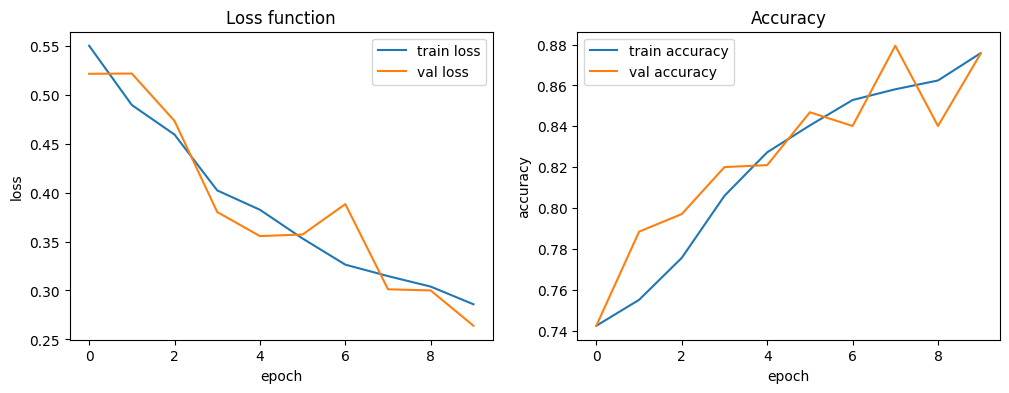

In [12]:
# Визуализация истории обучения
plt.figure(figsize=(12, 4))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

In [13]:
# Оценка модели на тестовых данных
test_results = model.evaluate(test_generator)

20/20 [==============================] - 24s 1s/step - loss: 0.6180 - accuracy: 0.6971 - precision: 0.6798 - recall: 0.9744


In [14]:
# метрики на тестовых данных
print("Test Accuracy:", test_results[1])
print("Test Precision:", test_results[2])
print("Test Recall:", test_results[3])

Test Accuracy: 0.6971153616905212
Test Precision: 0.6797853112220764
Test Recall: 0.9743589758872986


модель хорошо справляется с определением случаев пневмонии (высокий Recall), но при этом имеет большое количество ложноположительных результатов (низкий Precision).

В медицинских приложениях, которыми пользуются обычные люди, а не врачи, предпочтительнее минимизировать ложноположительные результаты.